#**Read Data**

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os

# statistics
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("data_file.csv")

In [ ]:
df.head()

,id,month,year,visits,no_of_appts,production
0,34,3,2014,1,960,76.55
1,34,4,2014,488,1089,106333.80
2,34,5,2014,831,993,192230.40
3,34,6,2014,753,884,163515.12
4,34,7,2014,721,797,160185.90


In [ ]:
df['dateInt']=df['year'].astype(str) + df['month'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['dateInt'], format='%Y%m')

# **Explortary Data Analysis**

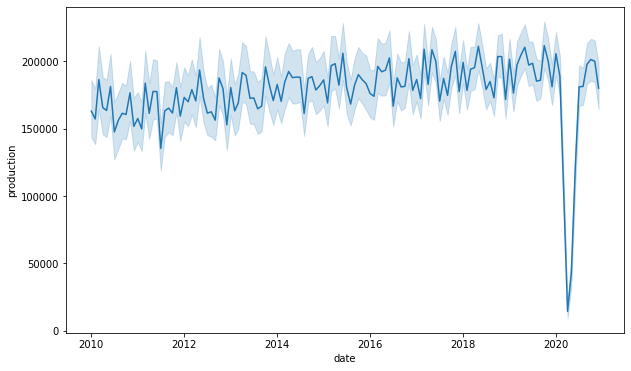

In [ ]:
# production time trend 
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y="production")

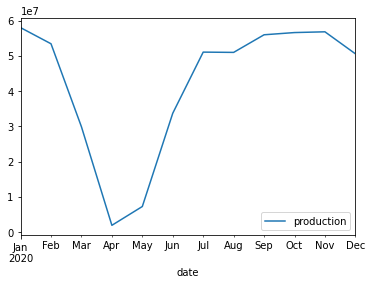

In [ ]:
# production for 2020
pd.DataFrame(df.loc[df['year']==2020].groupby(by='date')['production'].sum()).plot()

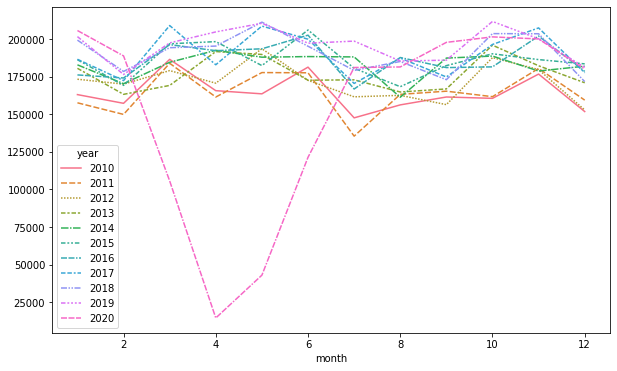

In [ ]:
# production for each year
df_wide = df.pivot_table(values='production', index='month', columns='year')
df_wide.head()
plt.figure(figsize=(10,6))
sns.lineplot(data=df_wide)

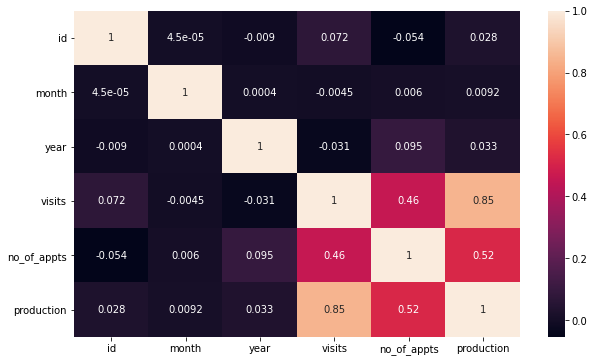

In [ ]:
# correlation map
plt.figure(figsize = (10, 6))
sns.heatmap(df.corr(), annot = True);

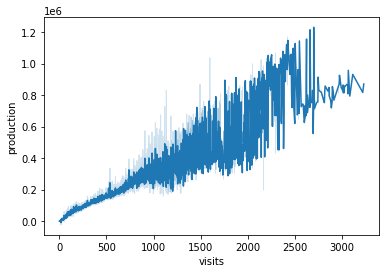

In [ ]:
# strong relationship between visits and production
sns.lineplot(data=df, x="visits", y="production")

In [ ]:
df = df.set_index('date')

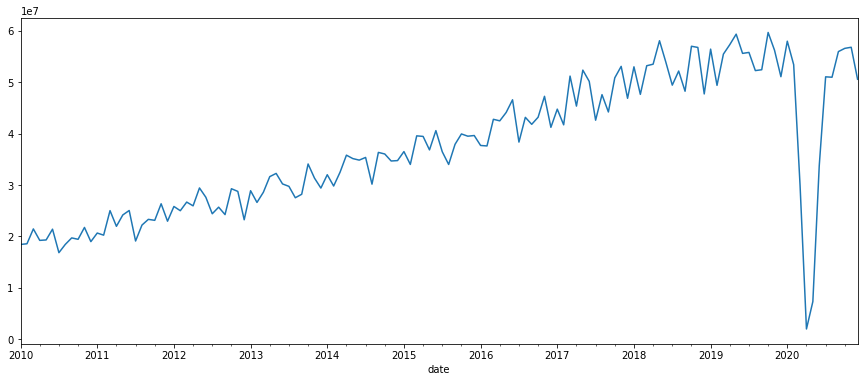

In [ ]:
plt.figure(figsize=(15,6))
df['production'].resample('M').sum().plot()

# **Modeling**

**Evaluation Metrics: MAPE (Mean Absolute Percentage Error)**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## **SARIMA (Seasonal Autoregressive Integrated Moving Average)**

Since 2020 data is special due to COVID-19, so I tried to train and validate model with data before 2020.

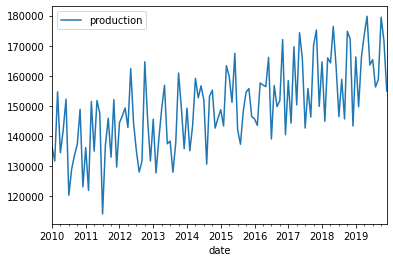

In [ ]:
train_all = df.loc[df.index <= '2019-12-31']
trainall_arima = train_all.resample("M").median()
trainall_arima = trainall_arima[["production"]]
trainall_arima.plot()

I applied one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


I used "grid search" to find the optimal set of parameters that yields the best performance for the model.

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainall_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3177.056754818585
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2791.5296777995604
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2258.913414806437
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2015.900370235305
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2269.327000122879
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2257.195221082942
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2032.288934485141
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2019.6083803395884
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3069.7079724090117
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2741.1291761217717
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2239.2355556355865
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1986.0931366036032
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2780.1525295896463
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2730.7670479642507
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2034.0458183028654
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1986.9627315645848
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2617.530591406717
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2307.2333269361225

We can see from the above grid search that our optimal parameter combination is ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2013.838899493845. So, let's use this in our model.

Next step is to fit the model. I used data before 2019 to train model and validate model using 2019 data.

In [ ]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(trainall_arima[:"2019-01-01"],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3548      0.163     -2.173      0.030      -0.675      -0.035
ma.L1         -0.7466      0.114     -6.568      0.000      -0.969      -0.524
ma.S.L12      -0.1068      0.142     -0.754      0.451      -0.384       0.171
sigma2      1.027e+08   3.06e-10   3.36e+17      0.000    1.03e+08    1.03e+08


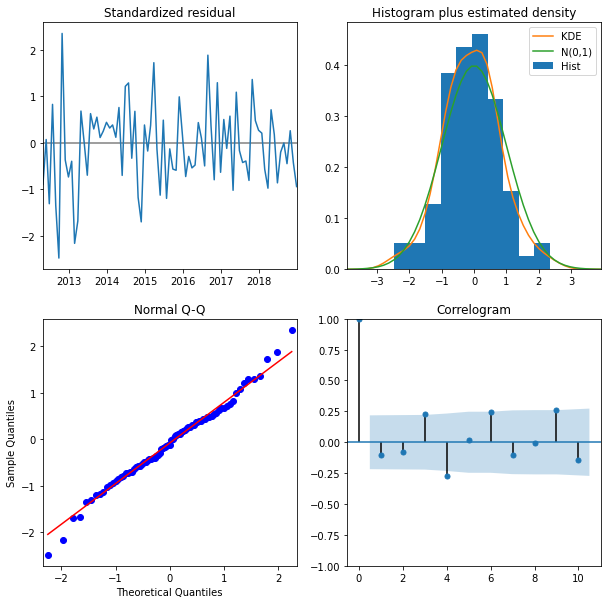

In [ ]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

To help us understand the accuracy of our forecasts, I compared predicted production to production of the time series, and we set forecasts to start at 2019–01–01 to 2019-12-31.

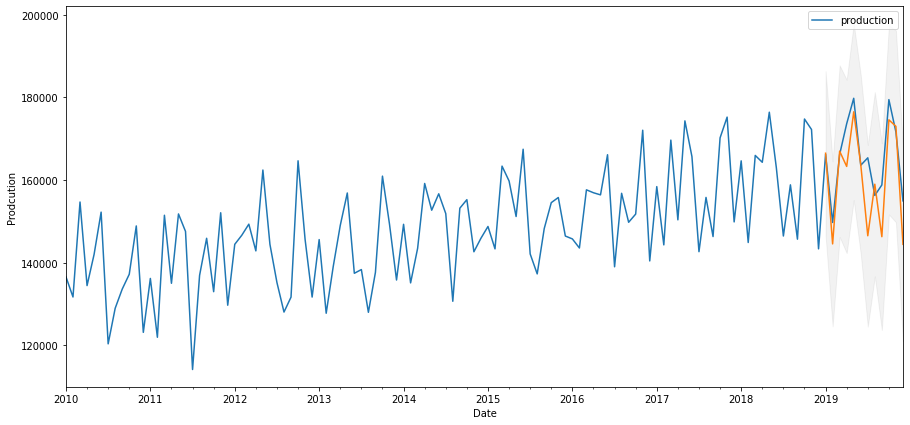

In [ ]:
# Model Prediction and validation 
pred = results_sarima.get_prediction(start=108, end=119, dynamic = True) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = trainall_arima["2010":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Prodcution")

plt.legend
plt.show()

testall_arima_forecasted = pred.predicted_mean
testall_arima_truth = trainall_arima["2019-01-01":]

The MAPE for the model is 3.6%, which is a good result. So I tried to use the parmater for the SARIMA model in all practices.

In [ ]:
# Calculating the error
mape_arima = mean_absolute_percentage_error(testall_arima_truth['production'], testall_arima_forecasted.values)
print(mape_arima)

3.6074273698274046


In [ ]:
# run SARIMA for each practice
d = {}
for i in df['id'].unique():
  train_name = 'train_' + str(i) + '_arima'
  df_new = train_all
  d[train_name] = pd.DataFrame(df_new.loc[df_new['id']==i].resample("M").median())['production']

# SARIMA model 
def model_performance(train_arima):
  model_sarima = sm.tsa.statespace.SARIMAX(train_arima.loc[train_arima.index < '2019-01-01'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  start_params = np.r_[[0] * (model_sarima.k_params - 1), 1]
  results_sarima = model_sarima.fit(start_params=start_params)

  # predction for 2019 production
  pred = results_sarima.get_prediction(start='2019-01-31', end='2019-12-31', dynamic = True) 
  train_arima_forecasted = pred.predicted_mean

  # model performance
  testall_arima_truth = train_arima.loc[train_arima.index >= '2019-01-01']
  mape_arima = mean_absolute_percentage_error(testall_arima_truth.values, train_arima_forecasted.values)

  return mape_arima

In [ ]:
# MAPE for each pratice
# for i in df['id'].unique():
#   score = model_performance(pd.DataFrame(df_new.loc[df_new['id']==i].resample("M").median())['production'])
#   print(i, score)

The last step is prediction. I used the data before 2020 to predict 2021 data using the ARIMA(1, 1, 1)x(0, 1, 1, 12) model.

In [ ]:
# SARIMA model 
def sarima_model(train_arima):
  model_sarima = sm.tsa.statespace.SARIMAX(train_arima.loc[train_arima.index <= '2019-12-31'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  start_params = np.r_[[0] * (model_sarima.k_params - 1), 1]
  results_sarima = model_sarima.fit(start_params=start_params)

  # predction for 2021 production
  pred = results_sarima.get_prediction(start='2021-01-31', end='2021-04-30', dynamic = True) 
  train_arima_forecasted = pred.predicted_mean
  
  return train_arima_forecasted

In [ ]:
# run SARIMA for each practice and make prediction
result = list()
for i in df['id'].unique():
  items = sarima_model(pd.DataFrame(df_new.loc[df_new['id']==i].resample("M").median())['production'])
  for row in items:
    result.append((i, row))

In [ ]:
# export data
import csv
with open('/content/test.csv', 'w') as f:
    write = csv.writer(f)
    #write.writerow(fields)
    write.writerows(result)

from google.colab import files
files.download('/content/test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>